<h1><center>Part A: Classification Problem</center></h1>

This project aims at building a convolutional neural network to detect and classify objects into one of the 10 categories defined in our dataset. We use the CIFAR-10 dataset to achieve this. 

## Loading dependencies


In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from keras.layers import Dropout

## Loading data


In [2]:
def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  # python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32) / 255
    labels = np.array(labels, dtype=np.int32)
    return data, labels

## Showing data


### Training Data


In [3]:
data, labels = load_data("/content/data_batch_1")

* **Data**: a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

* **Labels**: a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

In [4]:
print(f"Number of training data samples: {len(data)}\
  \nSize of each training data sample: {len(data[0])} " )

(unique, counts) = np.unique(labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(f"\nNumber of label samples: {len(labels)}" )
print(f"Unique label frequencies:-\n{frequencies}" )

Number of training data samples: 10000  
Size of each training data sample: 3072 

Number of label samples: 10000
Unique label frequencies:-
[[   0 1005]
 [   1  974]
 [   2 1032]
 [   3 1016]
 [   4  999]
 [   5  937]
 [   6 1030]
 [   7 1001]
 [   8 1025]
 [   9  981]]


### Testing Data

In [5]:
data, labels = load_data("/content/test_batch_trim")

In [6]:
print(f"Number of data samples: {len(data)}\
  \nSize of each data sample: {len(data[0])} " )

(unique, counts) = np.unique(labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(f"\nNumber of label samples: {len(labels)}" )
print(f"Unique label frequencies:-\n{frequencies}" )

Number of data samples: 2000  
Size of each data sample: 3072 

Number of label samples: 2000
Unique label frequencies:-
[[  0 200]
 [  1 200]
 [  2 200]
 [  3 200]
 [  4 200]
 [  5 200]
 [  6 200]
 [  7 200]
 [  8 200]
 [  9 200]]


## Creating the model

In [7]:
def make_model(num_ch_c1, num_ch_c2, use_dropout):

    model = tf.keras.Sequential()
    
    model.add(layers.Input(shape=(3072, )))
    model.add(layers.Reshape(target_shape=(32, 32, 3), input_shape=(3072,))) 
    
    model.add(layers.Conv2D(num_ch_c1, 9, activation='relu', input_shape=(32, 32, 3))) 
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    
    model.add(layers.Conv2D(num_ch_c2, 5, activation='relu')) 
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(300, use_bias=True))
    if(use_dropout):
      model.add(Dropout(0.5)) 
    model.add(layers.Dense(10, use_bias=True))  
    if(use_dropout):
      model.add(Dropout(0.5)) 

    return model

In [8]:
with tf.device('/device:GPU:0'):

  #Declaring variables
  seed = 0
  np.random.seed(seed)
  tf.random.set_seed(seed)

  num_ch_c1 = 50  
  num_ch_c2 = 60  

  epochs = 1000  
  batch_size = 128  
  learning_rate = 0.001
  optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
  use_dropout = False  
  metrics = ['accuracy']
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


  #Creating the model
  model = make_model(num_ch_c1, num_ch_c2, use_dropout)
  print(f"MODEL SUMMARY: {model.summary()}")


  # Loading Dataset
  x_train, y_train = load_data('/content/data_batch_1')
  x_test, y_test = load_data('/content/test_batch_trim')

  # Training
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  historyStarter = model.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(x_test, y_test),
      verbose = 0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 50)        12200     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 60)          75060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 60)          0         
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               2

## Question 1(a) - Plotting classification accuracies and costs for the model

Train accuracy: 0.7574999928474426
Test accuracy: 0.531000018119812


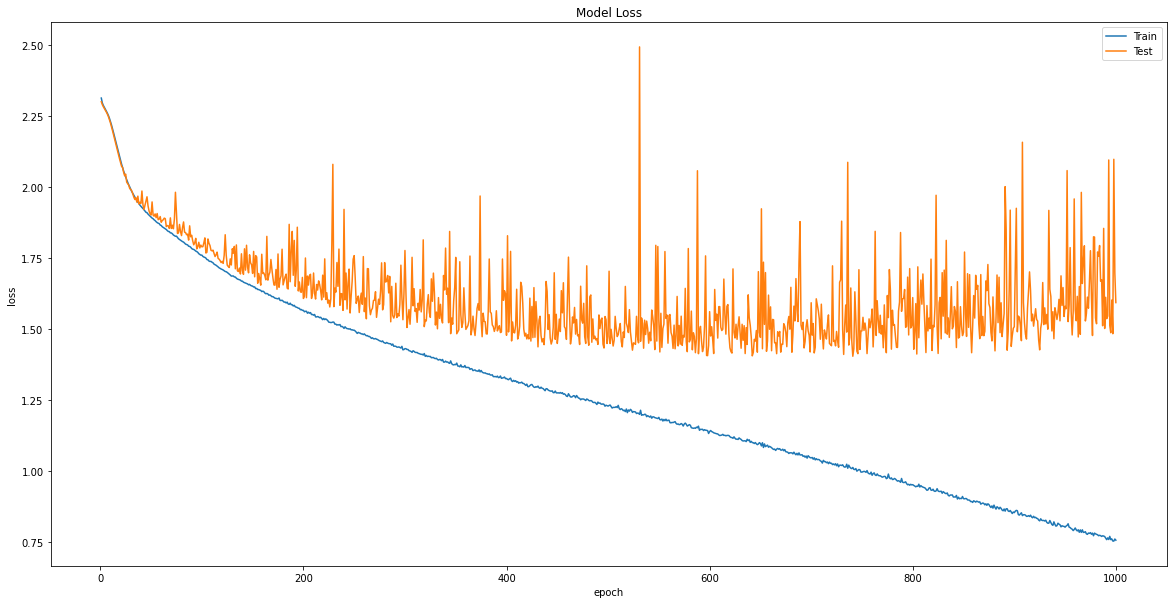

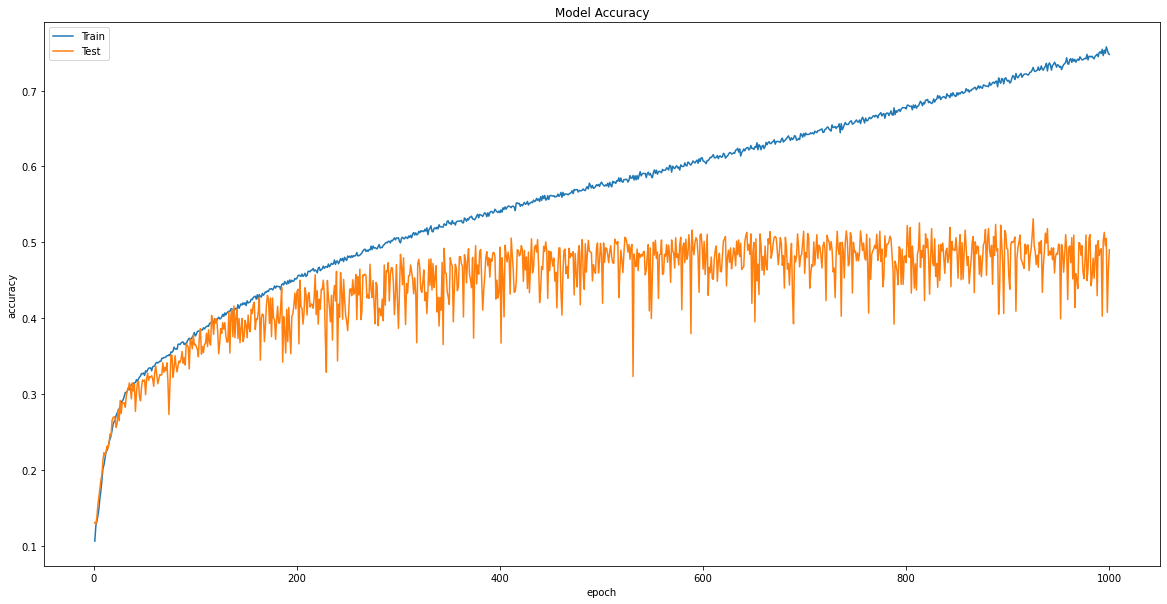

In [10]:
print(f"Train accuracy: {max(historyStarter.history['accuracy'])}\nTest accuracy: {max(historyStarter.history['val_accuracy'])}")

# Plot for losses
train_loss = historyStarter.history['loss']
val_loss = historyStarter.history['val_loss']

plt.figure(figsize=(20,10))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Test')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()    
plt.close()

# Plot for accuracies
train_acc = historyStarter.history['accuracy']
test_acc = historyStarter.history['val_accuracy']

plt.figure(figsize=(20,10))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()     
plt.close()

## Question 1(b) - Plotting Feature Maps



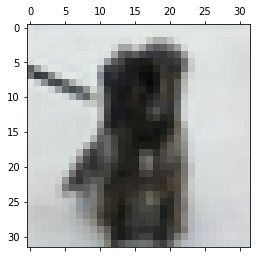

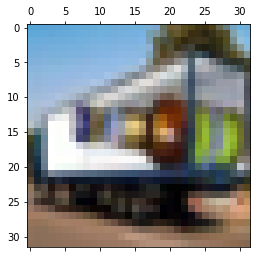

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


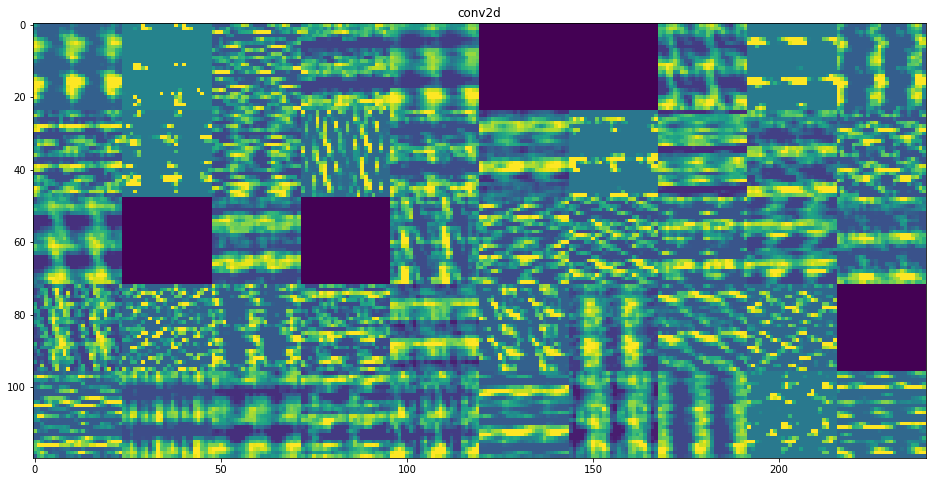

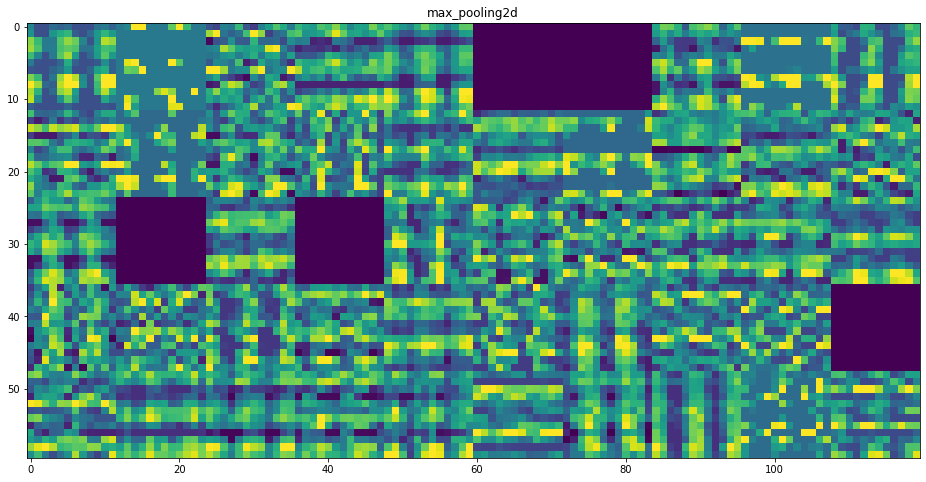

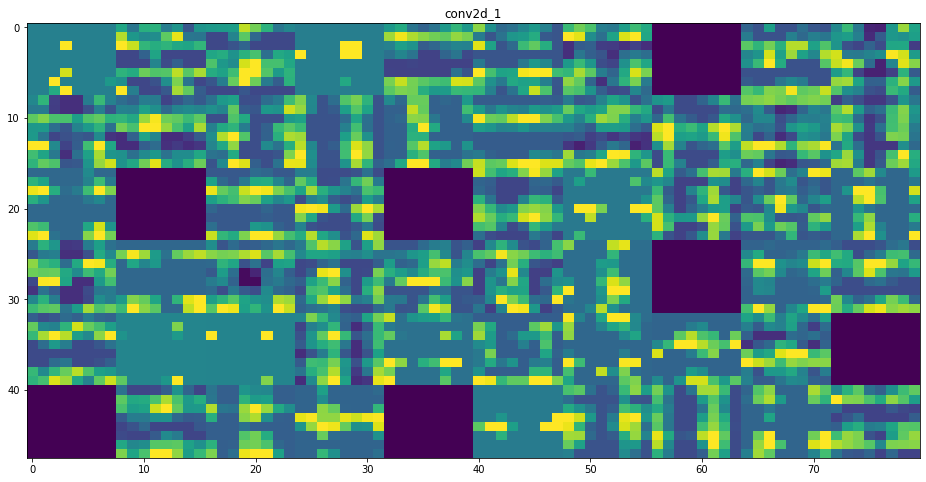

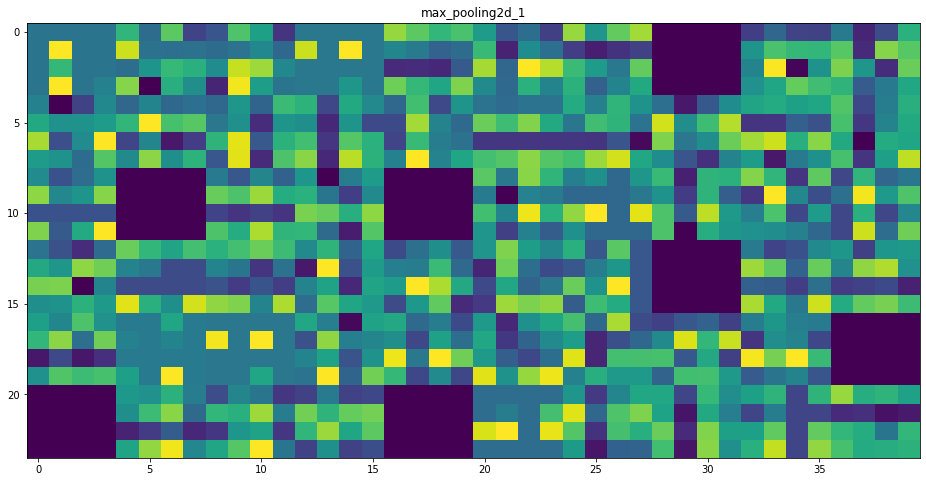

In [11]:
#Acquiring first and second test image and reshaping them
test_images = x_test.reshape(2000, 3, 32, 32).transpose(0,2,3,1)
test_image_1 = test_images[0]
test_image_2 = test_images[1]

#Displaying first two images
plt.matshow(test_image_1)
plt.matshow(test_image_2)
plt.show()
plt.close()      

#Getting the Feature Maps
layer_outputs = [layer.output for layer in model.layers[1:5]]

activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(x_test[1:2])

layer_names = []
grid_activations = {}

for layer in model.layers[1:5]:
  layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
  images_per_row = 10

  for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
      n_features = layer_activation.shape[-1] # Number of features in the feature map
      size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
      n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
      display_grid = np.zeros((size * n_cols, images_per_row * size))
      for col in range(n_cols): # Tiles each filter into a big horizontal grid
          for row in range(images_per_row):
              channel_image = layer_activation[0,
                                              :, :,
                                              col * images_per_row + row]
              channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
              channel_image /= channel_image.std()
              channel_image *= 64
              channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')
              display_grid[col * size : (col + 1) * size, # Displays the grid
                          row * size : (row + 1) * size] = channel_image

  scale = 1. / size

  #Displaying the feature maps
  plt.figure(figsize=(16,8))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')
  plt.show()
  plt.close() 

## Question 2 - Grid search for optimal combination of number of channels

In [12]:
with tf.device('/device:GPU:0'):  
  channel_1_sizes = [10, 30, 50, 70, 90]
  channel_2_sizes = [20, 40, 60, 80, 100]
  channel_sizes = ["10_20", "10_40", "10_60", "10_80", "10_100",
                   "30_20", "30_40", "30_60", "30_80", "30_100",
                   "50_20", "50_40", "50_60", "50_80", "50_100",
                   "70_20", "70_40", "70_60", "70_80", "70_100",
                   "90_20", "90_40", "90_60", "90_80", "90_100",]

  channel_histories = {}
  counter = 0

  for current_c1_size in channel_1_sizes:
    for current_c2_size in channel_2_sizes:

      epochs = 1000
      batch_size = 128  
      learning_rate = 0.001
      use_dropout = False  
      metrics = ['accuracy']
      loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
      optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

      # Training and test
      x_train, y_train = load_data('/content/data_batch_1')
      x_test, y_test = load_data('/content/test_batch_trim')

      current_model = make_model(current_c1_size, current_c2_size, use_dropout)

      current_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

      channel_histories[f"{current_c1_size}_{current_c2_size}"] = current_model.fit(
                                                                    x_train,
                                                                    y_train,
                                                                    batch_size=batch_size,
                                                                    epochs=epochs,
                                                                    validation_data=(x_test, y_test),
                                                                    verbose = 0)
      
      print(f"{channel_sizes[counter]} Complete :)")
      counter += 1

10_20 Complete :)
10_40 Complete :)
10_60 Complete :)
10_80 Complete :)
10_100 Complete :)
30_20 Complete :)
30_40 Complete :)
30_60 Complete :)
30_80 Complete :)
30_100 Complete :)
50_20 Complete :)
50_40 Complete :)
50_60 Complete :)
50_80 Complete :)
50_100 Complete :)
70_20 Complete :)
70_40 Complete :)
70_60 Complete :)
70_80 Complete :)
70_100 Complete :)
90_20 Complete :)
90_40 Complete :)
90_60 Complete :)
90_80 Complete :)
90_100 Complete :)


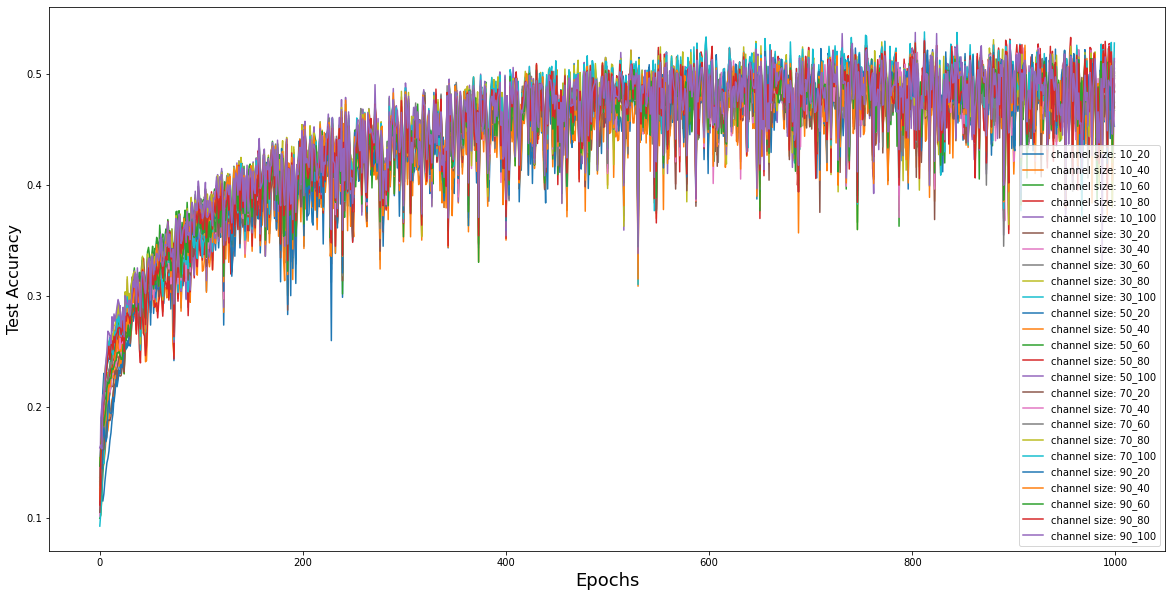

In [13]:
#Plotting epochs vs validation accuracy graph for each combination

plt.figure(figsize=(20,10))
for current_channel_size in channel_sizes:
    plt.plot(channel_histories[current_channel_size].history['val_accuracy'], label=f"channel size: {current_channel_size}")

plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Test Accuracy', fontsize=16)
plt.legend()
plt.show()

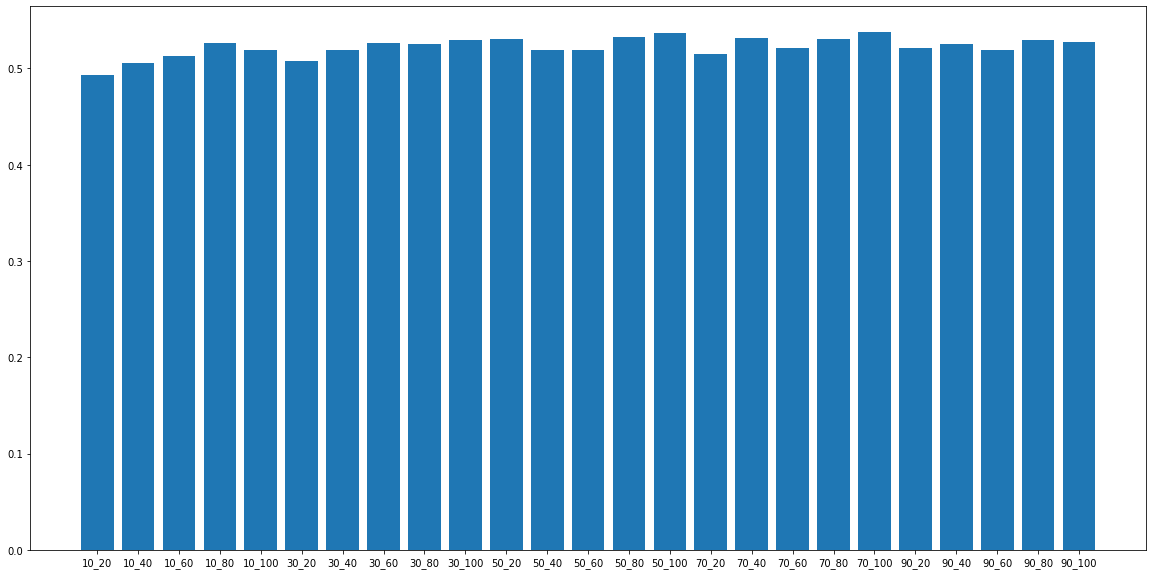

Best two selected channel lengths of 70_100 give us an accuracy of 0.5375000238418579


In [14]:
#plotting bar graph

channel_max_values = {}

for key, value in channel_histories.items():
  channel_max_values[key] = max(value.history['val_accuracy'])

plt.figure(figsize=(20,10))
plt.bar(range(len(channel_max_values)), list(channel_max_values.values()), align='center')
plt.xticks(range(len(channel_max_values)), list(channel_max_values.keys()))
plt.show()

max_value = max(channel_max_values.values())
max_key = list(channel_max_values.keys())[list(channel_max_values.values()).index(max_value)]

print(f"Best two selected channel lengths of {max_key} give us an accuracy of {max_value}")

In [15]:
NUM_CH_C1 = 70  
NUM_CH_C2 = 100

## Question 3 - Finding best optimizer

In [16]:
with tf.device('/device:GPU:0'):
  optimizer_list = ["Momentum", "RMSProp", "Adam", "SGD"]
  optimizer_histories = {}

  for current_optimizer in optimizer_list:

    epochs = 1000  
    batch_size = 128  
    learning_rate = 0.001    
    metrics = ['accuracy']
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    use_dropout = False
    
    #Optimizer
    if current_optimizer == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        use_dropout = True
    elif current_optimizer == 'Momentum':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,momentum=0.1)
    elif current_optimizer == 'RMSProp':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif current_optimizer == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        print("Wrong optimizer type")


    # Training and test
    x_train, y_train = load_data('/content/data_batch_1')
    x_test, y_test = load_data('/content/test_batch_trim')

    current_model = make_model(NUM_CH_C1, NUM_CH_C2, use_dropout)

    current_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    optimizer_histories[f"{current_optimizer}"] = current_model.fit(
                                                              x_train,
                                                              y_train,
                                                              batch_size=batch_size,
                                                              epochs=epochs,
                                                              validation_data=(x_test, y_test),
                                                              verbose = 0)

  

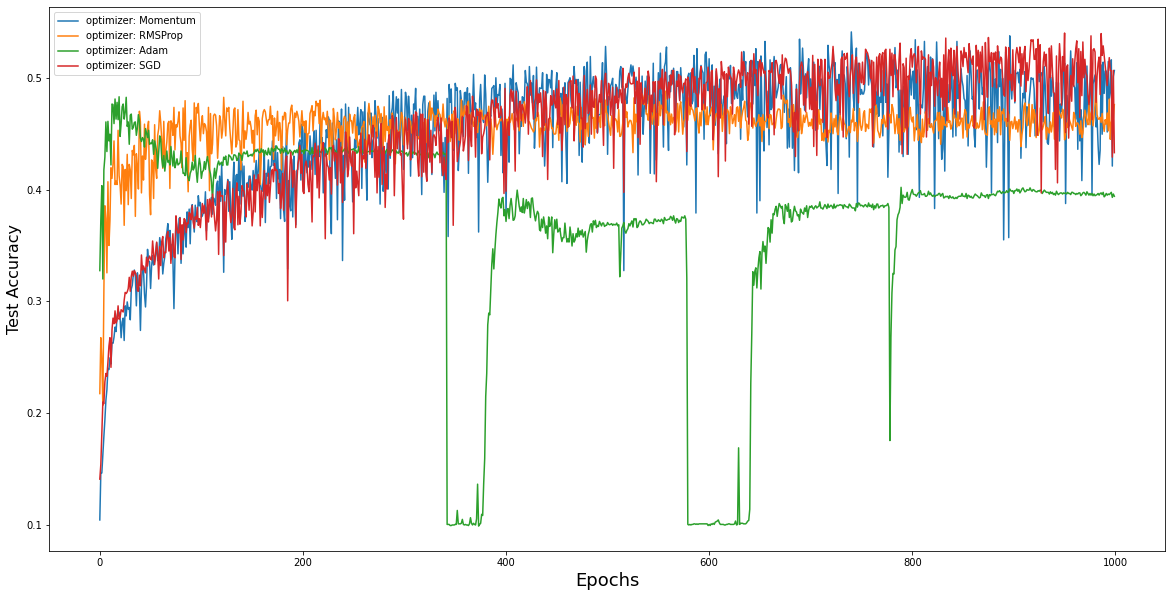

In [17]:
#Plotting Validation graphs for different optimizers

plt.figure(figsize=(20,10))
for current_optimizer in optimizer_list:
    plt.plot(optimizer_histories[current_optimizer].history['val_accuracy'], label=f"optimizer: {current_optimizer}")

plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Test Accuracy', fontsize=16)
plt.legend()
plt.show()

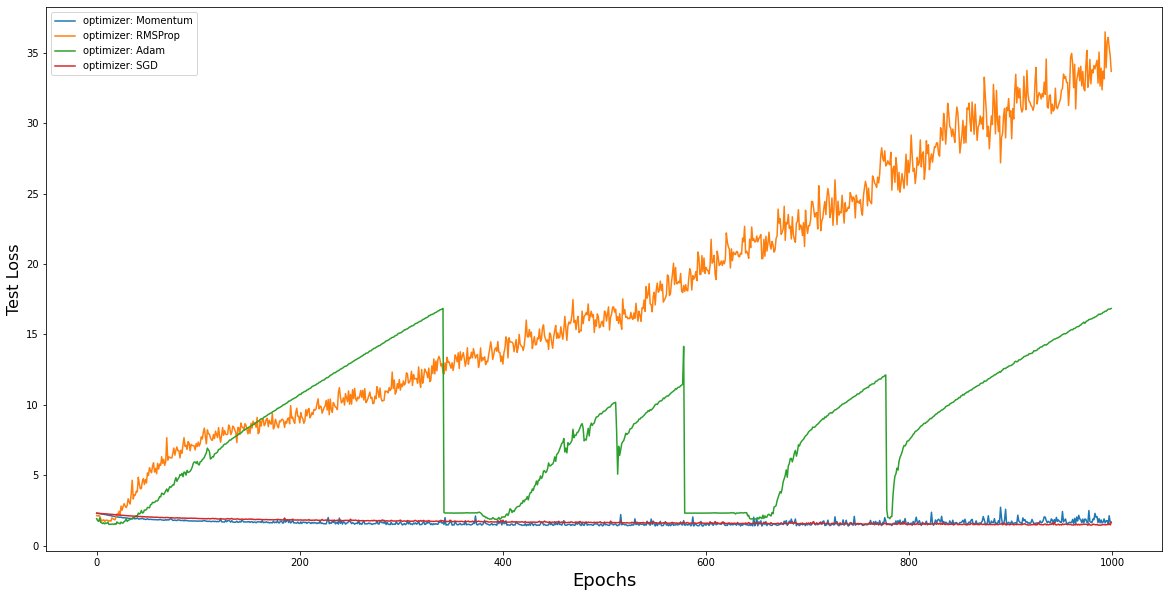

In [18]:
#Plotting loss graphs for different optimizers

plt.figure(figsize=(20,10))
for current_optimizer in optimizer_list:
    plt.plot(optimizer_histories[current_optimizer].history['val_loss'], label=f"optimizer: {current_optimizer}")

plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Test Loss', fontsize=16)
plt.legend()
plt.show()

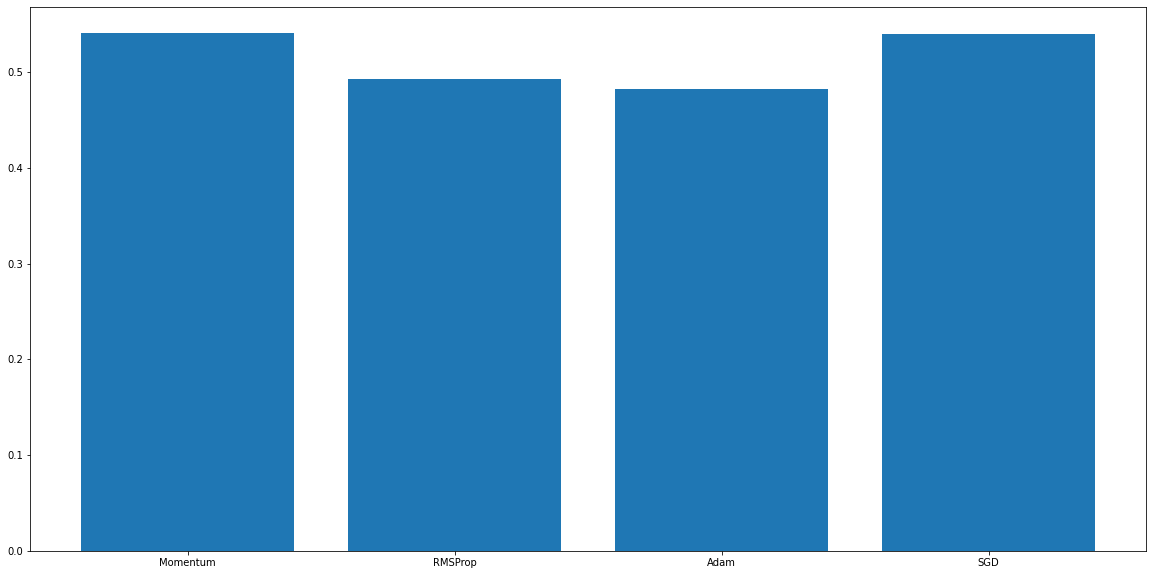

Best two selected channel lengths of Momentum give us an accuracy of 0.5410000085830688


In [19]:
#Plotting bar graphs for different optimizers accuracies

optimizer_max_values = {}

for key, value in optimizer_histories.items():
  optimizer_max_values[key] = max(value.history['val_accuracy'])

plt.figure(figsize=(20,10))
plt.bar(range(len(optimizer_max_values)), list(optimizer_max_values.values()), align='center')
plt.xticks(range(len(optimizer_max_values)), list(optimizer_max_values.keys()))
plt.show()

max_value = max(optimizer_max_values.values())
max_key = list(optimizer_max_values.keys())[list(optimizer_max_values.values()).index(max_value)]

print(f"Best two selected channel lengths of {max_key} give us an accuracy of {max_value}")

## [EXTRA] - Creating a new CNN

In [21]:
#Creating the model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from keras import initializers
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
 

def make_model_improved():

    model = tf.keras.Sequential() 
    model.add(layers.Input(shape=(3072, )))
    model.add(layers.Reshape(target_shape=(32, 32, 3), input_shape=(3072,))) 
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(10))

    return model

In [22]:
with tf.device('/device:GPU:0'):

  # Setting variables
  seed = 0
  np.random.seed(seed)
  tf.random.set_seed(seed)

  epochs = 1000  # Fixed
  batch_size = 128  # Fixed
  learning_rate = 0.001
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  metrics = ['accuracy']
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  # Creating model
  model_improved = make_model_improved()
  print(f"MODEL SUMMARY: {model_improved.summary()}")

  # Loading data
  x_train, y_train = load_data('/content/data_batch_1')
  x_test, y_test = load_data('/content/test_batch_trim')

  # Training
  model_improved.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  history_improved = model_improved.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(x_test, y_test),
      verbose = 0)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_30 (Reshape)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 32)      

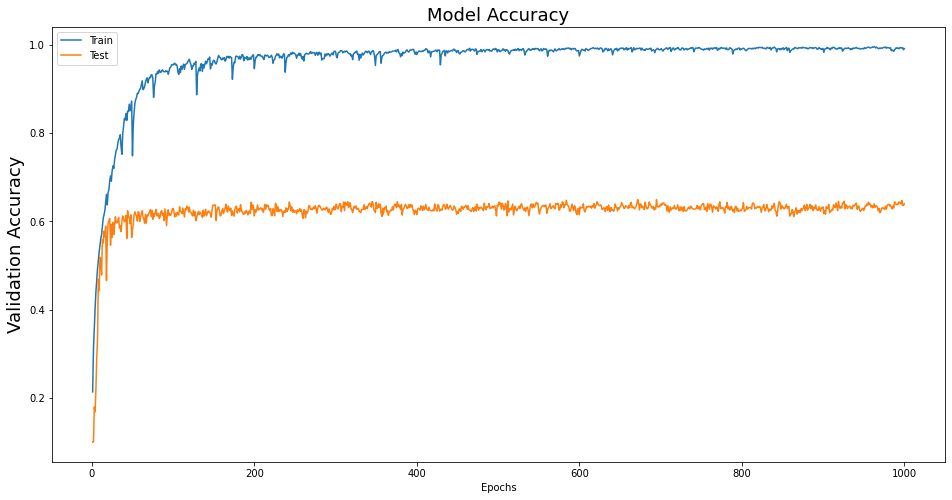

In [23]:
#Plotting validation accuracy graph
train_acc = history_improved.history['accuracy']
test_acc = history_improved.history['val_accuracy']

plt.figure(figsize=(16,8))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test')
plt.title('Model Accuracy', fontsize=18)
plt.ylabel('Validation Accuracy', fontsize=18)
plt.xlabel('Epochs')
plt.legend()
plt.show()     
plt.close()

In [24]:
max(history_improved.history['val_accuracy'])

0.6495000123977661